<br/>

$$ \huge{\underline{\textbf{ Playing Atari Games with Deep RL }}} $$

$$ \large{\textbf{MountainCar + DQN + Memory Reply}} $$

<br/>



In [10]:
def q_learning(env, frames, gamma, eps_decay_steps, eps_target,
               batch_size, model, mem, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        model      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, model, eps):
        if np.random.rand() > eps:
            q_values = model.eval(np.array([st]))
            return argmax_rand(q_values)
        else:
            return env.action_space.sample()
    
    if eps_decay_steps is not None:
        eps_delta = (1-eps_target) / eps_decay_steps
        eps = 1
    else:
        eps = eps_target
        
    # Fill memory buffer using random policy
    while len(mem) < mem.max_len:
        S = env.reset();
        while True:
            A = policy(S, model, eps=1.0)  # random policy
            S_, R, done, _ = env.step(A)
            mem.append(S, A, R, S_, done)
            if done:
                break
            S = S_

    tts_ = 0                                 # total time step
    for e_ in itertools.count():             # count from 0 to infinity
        
        S = env.reset()
        
        for t_ in itertools.count():         # count from 0 to infinity
            
            A = policy(S, model, eps)
            
            S_, R, done, _ = env.step(A)
            
            mem.append(S, A, R, S_, done)
            
            if callback is not None:
                callback(e_, t_, S, A, R, done, eps, model, mem, trace)
            
            states, actions, rewards, n_states, dones, _ = mem.get_batch(batch_size)
            targets = model.eval(n_states)
            targets = rewards + gamma * np.max(targets, axis=-1)
            targets[dones] = rewards[dones]                # return of next-to-terminal state is just R
            model.train(states, actions, targets)

            if done:
                break
                
            if tts_ >= frames:
                return
                
            S = S_
            
            if eps > eps_target:
                eps = max(eps - eps_delta, eps_target)
                
            tts_ += 1

In [ ]:
# def test_car(env, ep, model, callback=None, trace=None):

#     def policy(st, model):
#         q_values = model.eval([st])
#         return argmax_rand(q_values)
    
#     for e_ in range(ep):
        
#         S = env.reset()
        
        
#         for t_ in range(1000):       
        
#             A = policy(S, model)
#             S_, R, done, _ = env.step(A)
            
#             if callback is not None:
#                 if t_ == 999:  done=True
#                 callback(e_, t_, S, A, R, done, 0, model, None, trace)
            
#             if done:
#                 break
                
#             S = S_

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

Helper functions

In [11]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [12]:
def running_mean(x, n):
    # res = []
    # for i in range(len(x)):
    #     res.append( sum(x[max(i-n+1, 0): i+1])   /   min(i+1, n) )
        
    return [sum(x[max(i-n+1, 0): i+1])   /   min(i+1, n) for i in range(len(x))]
        
    return res

---

# Experiment Setup

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import itertools
import collections
import mountain_car
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

import tensorflow as tf

Environment

In [ ]:
import importlib
importlib.reload(mountain_car)
# from mountain_car import MountainCarEnv

In [ ]:
env = mountain_car.MountainCarEnv()

In [15]:
import gym

In [16]:
env = gym.make('MountainCar-v0').env

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
env = gym.make('Pendulum-v0')

In [ ]:
class PendulumEnv():
    def __init__(self):
        self._env = gym.make('Pendulum-v0')
        self.state_low = np.array([-np.pi, -8.0])
        self.state_high = np.array([np.pi, 8.0])
        self.act_space = np.array([0, 1, 2])
        print(self._env)
        
    def reset(self):
        sin, cos, vel = self._env.reset()
        theta = np.arctan2(cos, sin)
        return np.array([theta, vel])
        
    def step(self, action):
        # torques = [-2.0, 0.0, 2.0]
        torques = [-0.1, 0.0, 0.1]
        joint_effort = torques[action]
        
        obs, rew, done, _ = self._env.step([joint_effort])
        sin, cos, vel = obs
        theta = np.arctan2(cos, sin)
        return np.array([theta, vel]), rew, done, None

In [ ]:
env = PendulumEnv()

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [17]:
class Trace():
    def __init__(self):
        self.total_tstep = 0
        
        self.q_values = collections.OrderedDict()
        self.ep_end_idx = collections.OrderedDict()
        self.ep_rewards = collections.defaultdict(float)
        
        self.states = []
        self.actions = []
        self.rewards = []  # t+1
        self.dones = []    # t+1
        self.epsilons = []

In [18]:
def callback(episode, tstep, st, act, rew_, done_, eps, model, memory, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
        
    if done_:
        trace.ep_end_idx[episode] = trace.total_tstep
    
    trace.states.append(st)
    trace.actions.append(act)
    trace.rewards.append(rew_)
    trace.dones.append(done_)
    trace.epsilons.append(eps)
    
    trace.ep_rewards[episode] += rew_
        
    if trace.total_tstep % 1000 == 0:
        print('-'*80)
        print('episode:', episode, '\t time step:', tstep,
              '\t total time step:', trace.total_tstep, '\t eps:', round(eps,3))
        
    if trace.total_tstep % 1000 == 0:
        q_arr = eval_state_action_space(model, env)
        trace.q_values[trace.total_tstep] = q_arr
        
        plot_mountain_car(env, episode, trace.total_tstep, 1000, trace, memory)
        
    trace.total_tstep += 1

---

# Solve with Tiles (batch=1)

In [ ]:
def experiment_tiles_single(frames, trace=None):
    
    model = TileCodingFuncApprox(env.observation_space.low, env.observation_space.high, env.action_space.n,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=1, state_shape=(2,), state_dtype=float)
    
    q_learning(env, frames=frames, gamma=1.0, eps_random_steps=0, eps_decay_steps=None, eps_target=0.0, batch_size=1,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [ ]:
trace_t_s_1 = experiment_tiles_single(frames=20000)

# Solve with Tiles (batch=16)

In [ ]:
def experiment_tiles_batch(frames):
    
    trace = Trace()
    
    model = TileCodingFuncApprox(env.observation_space.low, env.observation_space.high, env.action_space.n,
                                 learn_rate=0.3, num_tilings=8, init_val=0)
    
    mem = Memory(max_len=1000, state_shape=(2,), state_dtype=float)
    
    q_learning(env, frames=frames, gamma=1.0, eps_decay_steps=None, eps_target=0.0, batch_size=64,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

In [ ]:
trace_t_b_1 = experiment_tiles_batch(frames=5000)

# Solve with Neural Net (batch=4096)

In [19]:
def experiment_keras(frames):
    
    keras_model = tf.keras.models.Sequential()
    keras_model.add(tf.keras.layers.Dense(256, 'relu', input_dim=2))
    keras_model.add(tf.keras.layers.Dense(256, 'relu'))
    keras_model.add(tf.keras.layers.Dense(3, 'linear'))
    keras_model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=0.00025))
    
    model = KerasFunctApprox(keras_model, env.observation_space.low, env.observation_space.high, env.action_space.n)
    
    mem = Memory(max_len=100000, state_shape=(2,), state_dtype=float)
    
    trace = Trace()
    q_learning(env, frames=frames, gamma=.99, eps_decay_steps=50000, eps_target=0.1, batch_size=4096, #8192,
               model=model, mem=mem, callback=callback, trace=trace)
    
    #test_car(env, ep=20, model=model, callback=callback, trace=trace)
    print()
    return trace

--------------------------------------------------------------------------------
episode: 0 	 time step: 0 	 total time step: 0 	 eps: 1


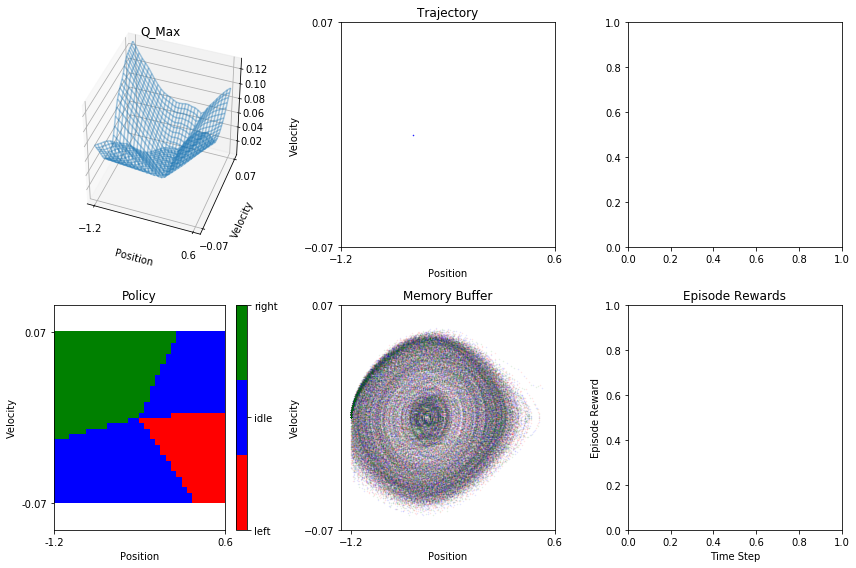

--------------------------------------------------------------------------------
episode: 0 	 time step: 1000 	 total time step: 1000 	 eps: 0.982


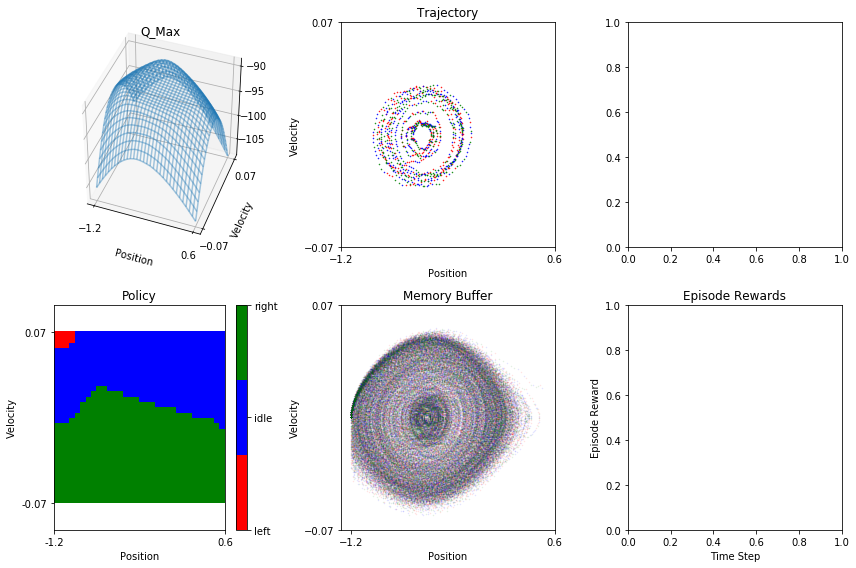

--------------------------------------------------------------------------------
episode: 0 	 time step: 2000 	 total time step: 2000 	 eps: 0.964


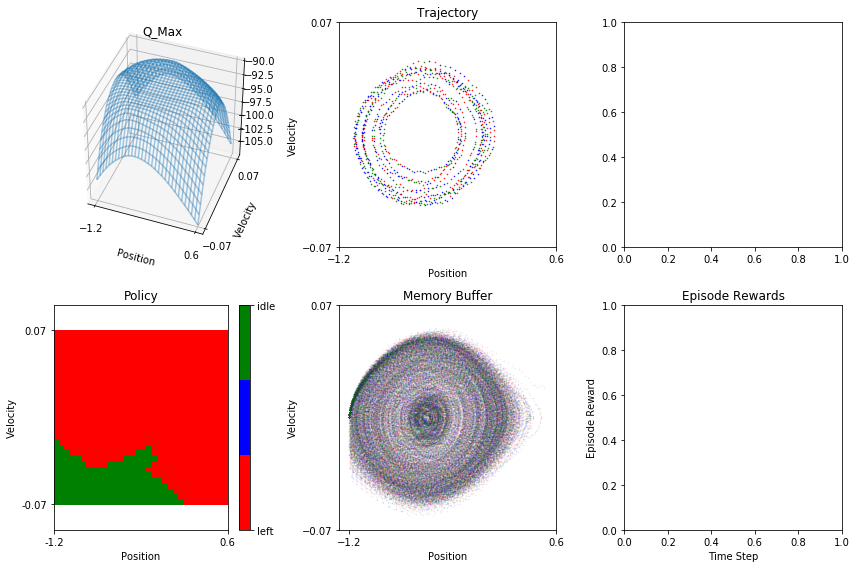

--------------------------------------------------------------------------------
episode: 0 	 time step: 3000 	 total time step: 3000 	 eps: 0.946


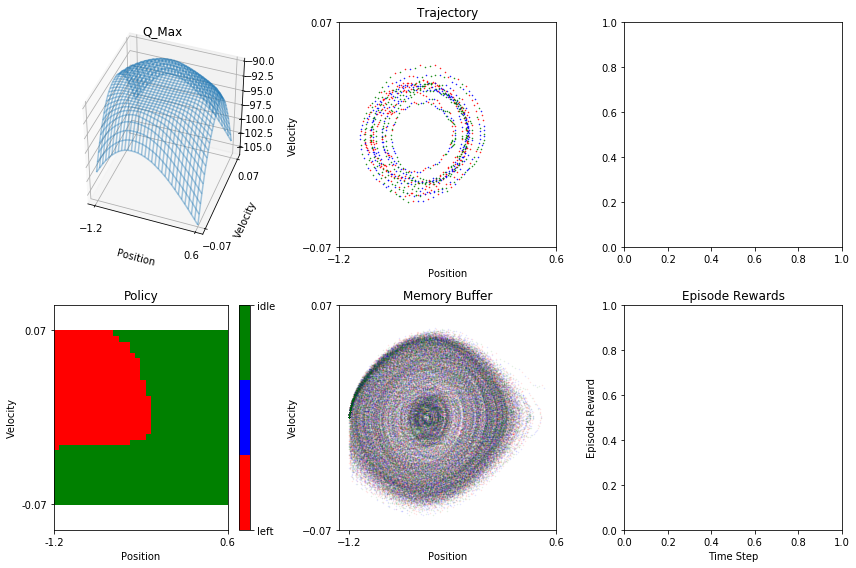

--------------------------------------------------------------------------------
episode: 0 	 time step: 4000 	 total time step: 4000 	 eps: 0.928


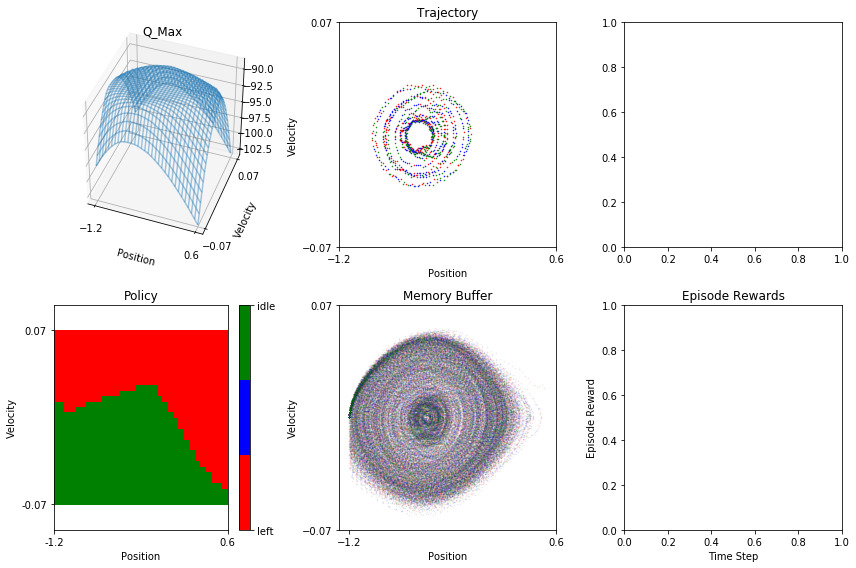

--------------------------------------------------------------------------------
episode: 0 	 time step: 5000 	 total time step: 5000 	 eps: 0.91


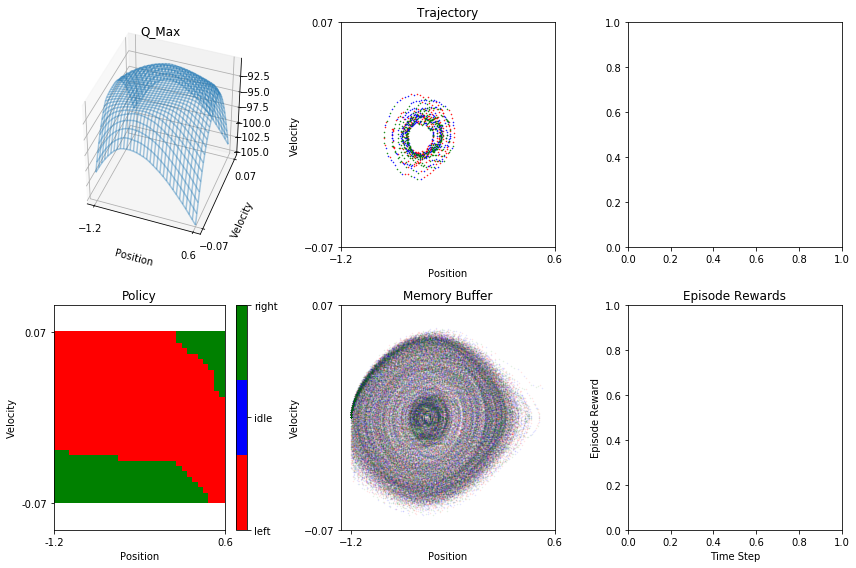

--------------------------------------------------------------------------------
episode: 0 	 time step: 6000 	 total time step: 6000 	 eps: 0.892


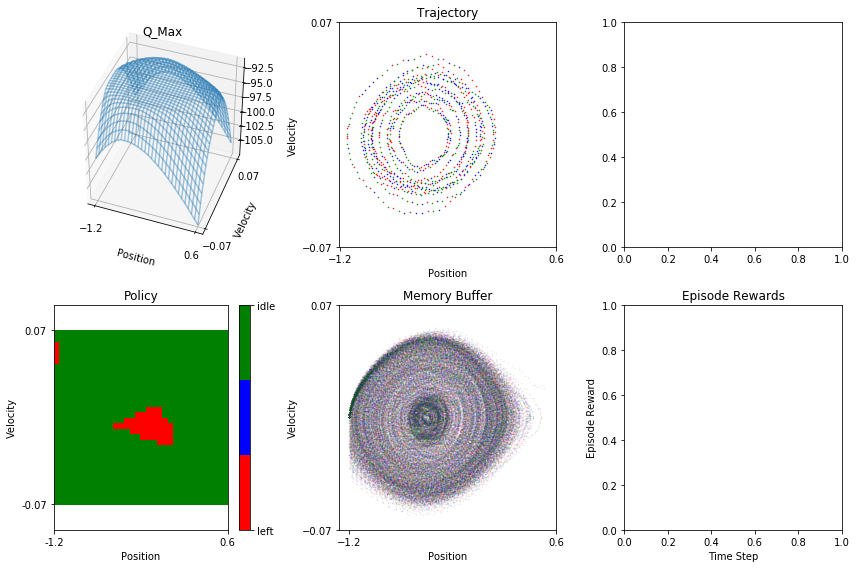

--------------------------------------------------------------------------------
episode: 0 	 time step: 7000 	 total time step: 7000 	 eps: 0.874


KeyboardInterrupt: 

<Figure size 864x576 with 0 Axes>

In [20]:
trace_ker_1 = experiment_keras(frames=100000)

---

# Appendix - function definitions

In [1]:
def plot_mountain_car(env, episode, total_tstep, steps_to_plot, trace, mem):
    
    q_arr = trace.q_values[total_tstep]
    states = trace.states[-steps_to_plot:]
    actions = trace.actions[-steps_to_plot:]
    
    epsilons = trace.epsilons
    
    fig = plt.figure(figsize=[12,8])

    if q_arr is not None:
        ax = fig.add_subplot(231, projection='3d')
        plot_q_max_3d(q_arr, env, title='Q_Max', 
                      labels=['Position', 'Velocity', ''], alpha=.4, axis=ax)

    ax = fig.add_subplot(232)
    plot_trajectory(states, actions, env, title='Trajectory', labels=['Position', 'Velocity'], axis=ax)
    
    ax = fig.add_subplot(233)
    # ax.plot(epsilons)
    
    if q_arr is not None:
        ax = fig.add_subplot(234)
        plot_policy(q_arr, env, labels=['Position', 'Velocity'],
                    colors=['red', 'blue','green'], collab=['left', 'idle', 'right'], axis=ax)
        
    ax = fig.add_subplot(235)
    st, act, rew_1, st_1, dones_1, _ = mem.pick_last(len(mem))
    plot_trajectory(st, act, env, title='Memory Buffer', labels=['Position', 'Velocity'], alpha=0.1, axis=ax)
    
    ax = fig.add_subplot(236)
    plot_episode_rewards(trace.ep_end_idx, trace.ep_rewards, ax)

    plt.tight_layout()
    plt.show()

In [2]:
def plot_episode_rewards(ep_end_dict, rew_dict, axis=None):
    
    tsteps = []    # episodes end tsteps
    rewards = []   # episodes rewards
    
    for ep, end_tstep in ep_end_dict.items():
        tsteps.append(end_tstep)
        rewards.append(rew_dict[ep])
    
    rewards_avg = running_mean(rewards, 10)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
    
    if len(tsteps) > 0:
        axis.scatter(tsteps, rewards, alpha=0.5, marker='.')
        axis.plot(tsteps, rewards_avg, alpha=1)
        axis.plot([0, tsteps[-1]], [-200, -200], color='gray', linestyle='--')
    axis.set_xlabel('Time Step')
    axis.set_ylabel('Episode Reward')
    axis.set_title('Episode Rewards')
    

In [3]:
def plot_trajectory(states, actions, env, title, labels, alpha=1.0, axis=None):
    if not isinstance(states, np.ndarray): states = np.array(states)
    if not isinstance(actions, np.ndarray): actions = np.array(actions)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
    
    if len(states) == 0:
        axis.scatter(np.array([]), np.array([]))
    else:
        axis.scatter(states[actions==0,0], states[actions==0,1], marker='.', s=1, color='red', alpha=alpha)
        axis.scatter(states[actions==1,0], states[actions==1,1], marker='.', s=1, color='blue', alpha=alpha)
        axis.scatter(states[actions==2,0], states[actions==2,1], marker='.', s=1, color='green', alpha=alpha)
        
    x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
    y_min, y_max = env.observation_space.low[1], env.observation_space.high[1]
    axis.set_xticks([x_min, x_max])
    #axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([y_min, y_max])
    #axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_title(title)

In [4]:
def plot_policy(q_arr, env, labels, colors, collab, axis=None):
    q_pol = np.argmax(q_arr, axis=-1)
    
    cmap = ListedColormap(colors)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111)
        
    heatmap = axis.pcolormesh(q_pol.T, cmap=cmap)
    axis.set_aspect('equal', 'datalim')
    cbar = plt.colorbar(heatmap)
    cbar.set_ticks(range(len(collab)))
    cbar.set_ticklabels(collab)
    
    x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
    y_min, y_max = env.observation_space.low[1], env.observation_space.high[1]
    axis.set_xticks([0, q_arr.shape[0]])
    axis.set_xticklabels([x_min,x_max])
    axis.set_yticks([0, q_arr.shape[1]])
    axis.set_yticklabels([y_min,y_max])
    
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_title('Policy')

In [5]:
def plot_q_max_3d(q_arr, env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe
    
    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = np.max(q_arr, axis=-1)  # calc max and inverse
    
    x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
    y_min, y_max = env.observation_space.low[1], env.observation_space.high[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)
    
    axis.view_init(40, -70)

In [6]:
def eval_state_action_space(model, env, split=[32,32]):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        model     - function approximator with method: model.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = env.observation_space.low[0], env.observation_space.high[0]
    y_min, y_max = env.observation_space.low[1], env.observation_space.high[1]
    x_split, y_split = split
    
    q_arr = np.zeros([x_split, y_split, env.action_space.n])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            q_values = model.eval(states=np.array([[pos, vel]]))[0]
            for act in range(env.action_space.n):
                q_arr[pi, vi, act] = q_values[act]
                
    return q_arr

# Function Approximators and Memory

In [7]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low       - state space low boundry, e.g. [-1.2, -0.07] for mountain car
            st_high      - state space high boundry in all dimensions
            action_space - list of possible actions
            learn_rate   - step size, will be adjusted for nb_tilings automatically
            num_tilings  - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val     - initial state-action values
        """
        st_low = np.array(st_low);    st_high = np.array(st_high)
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._nb_actions = nb_actions
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * nb_actions
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2
        
        all_q_values = []
        for state in states:
            assert len(state) == self._n_dim
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            q_values = []
            for action in range(self._nb_actions):
                active_tiles = tiles3.tiles(                 # find active tiles
                    self._iht, self._num_tilings,
                    scaled_state, [action])
                q_val = np.sum(self._weights[active_tiles])  # pick correct weights and sum up
                q_values.append(q_val)                       # store result for this action
            all_q_values.append(q_values)
        return np.array(all_q_values)

    def train(self, states, actions, targets):
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)
        
        for i in range(len(states)):
            state = states[i]
            action = actions[i]
            target = targets[i]
            
            assert len(state) == self._n_dim
            assert np.isscalar(action)
            assert np.isscalar(target)
            
            scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
            active_tiles = tiles3.tiles(                     # find active tiles
                self._iht, self._num_tilings,
                scaled_state, [action])
            value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
            delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
            self._weights[active_tiles] += delta             # ..so we pick active weights instead

In [8]:
class KerasFunctApprox():

    def __init__(self, model, st_low, st_high, nb_actions):
        """Q-function approximator using Keras model

        Args:
            model: Keras compiled model
        """
        st_low = np.array(st_low);    st_high = np.array(st_high)
        self._model = model
    
        first_layer = self._model.layers[0]
        nn_input_shape = first_layer.input_shape[1:]
        if st_low.shape != nn_input_shape:
            raise ValueError('Input shape does not match state_space shape')

        last_layer = self._model.layers[-1]
        nn_output_shape = last_layer.output_shape[1:]
        if (nb_actions,) != nn_output_shape:
            raise ValueError('Output shape does not match action_space shape')

        # normalise inputs
        self._offsets = st_low + (st_high - st_low) / 2
        self._scales = 1 / ((st_high - st_low) / 2)

    def eval(self, states):
        assert isinstance(states, np.ndarray)
        assert states.ndim == 2

        inputs = (states - self._offsets) * self._scales

        return self._model.predict(inputs, batch_size=len(inputs))

    def train(self, states, actions, targets):
        
        assert isinstance(states, np.ndarray)
        assert isinstance(actions, np.ndarray)
        assert isinstance(targets, np.ndarray)
        assert states.ndim == 2
        assert actions.ndim == 1
        assert targets.ndim == 1
        assert len(states) == len(actions) == len(targets)

        inputs = (states - self._offsets) * self._scales
        all_targets = self._model.predict(inputs, batch_size=len(inputs))
        all_targets[np.arange(len(all_targets)), actions] = targets
        self._model.fit(inputs, all_targets, batch_size=len(inputs), epochs=1, verbose=False)


In [9]:
class Memory:
    """Circular buffer for DQN memory reply. Fairly fast."""

    def __init__(self, max_len, state_shape, state_dtype):
        """
        Args:
            max_len: maximum capacity
        """
        assert isinstance(max_len, int)
        assert max_len > 0

        self.max_len = max_len                            # maximum length        
        self._curr_insert_ptr = 0                          # index to insert next data sample
        self._curr_len = 0                                 # number of currently stored elements

        state_arr_shape = [max_len] + list(state_shape)

        self._hist_St = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_At = np.zeros(max_len, dtype=int)
        self._hist_Rt_1 = np.zeros(max_len, dtype=float)
        self._hist_St_1 = np.zeros(state_arr_shape, dtype=state_dtype)
        self._hist_done_1 = np.zeros(max_len, dtype=bool)

    def append(self, St, At, Rt_1, St_1, done_1):
        """Add one sample to memory, override oldest if max_len reached.

        Args:
            St [np.ndarray]   - state
            At [int]          - action
            Rt_1 [float]      - reward
            St_1 [np.ndarray] - next state
            done_1 [bool]       - next state terminal?
        """
        self._hist_St[self._curr_insert_ptr] = St
        self._hist_At[self._curr_insert_ptr] = At
        self._hist_Rt_1[self._curr_insert_ptr] = Rt_1
        self._hist_St_1[self._curr_insert_ptr] = St_1
        self._hist_done_1[self._curr_insert_ptr] = done_1
        
        if self._curr_len < self.max_len:                 # keep track of current length
            self._curr_len += 1
            
        self._curr_insert_ptr += 1                         # increment insertion pointer
        if self._curr_insert_ptr >= self.max_len:         # roll to zero if needed
            self._curr_insert_ptr = 0

    def __len__(self):
        """Number of samples in memory, 0 <= length <= max_len"""
        return self._curr_len

    def get_batch(self, batch_len):
        """Sample batch of data, with repetition

        Args:
            batch_len: nb of samples to pick

        Returns:
            states, actions, rewards, next_states, next_done, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert self._curr_len > 0
        assert batch_len > 0

        
        indices = np.random.randint(                   # randint much faster than np.random.sample
            low=0, high=self._curr_len, size=batch_len, dtype=int)

        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)

        return states, actions, rewards_1, states_1, dones_1, indices


    
    def pick_last(self, nb):
        """Pick last nb elements from memory
        
        Returns:
            states, actions, rewards, next_states, done_1, indices
            Each returned element is np.ndarray with length == batch_len
        """
        assert nb <= self._curr_len
        
        start = self._curr_insert_ptr - nb                # inclusive
        end = self._curr_insert_ptr                       # not inclusive
        indices = np.array(range(start,end), dtype=int)   # indices to pick, can be negative
        indices[indices < 0] += self._curr_len            # loop negative to positive
        
        states = np.take(self._hist_St, indices, axis=0)
        actions = np.take(self._hist_At, indices, axis=0)
        rewards_1 = np.take(self._hist_Rt_1, indices, axis=0)
        states_1 = np.take(self._hist_St_1, indices, axis=0)
        dones_1 = np.take(self._hist_done_1, indices, axis=0)
        
        return states, actions, rewards_1, states_1, dones_1, indices
    